# Interpret the results obtained from each of the experiments

The results from the experiments involve interpreting and plotting several quantities
- CPU Utilization of the slaves during the experiments
- IO Wait of the slaves during the experiments
- Accuracy of the final model after 10 epochs
- Response time of the model after 10 epochs

(Possible other result to see)
- Throughput of the model

In [2]:
import math
import numpy as np
import pandas as pd
from collections import defaultdict
import glob
import os
import pickle

# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols


## Extract from the log files the Accuracy and the Response Time

The files are in the folder from the master server, and we get a final line in the files with
the total wall clock time and the final accuracy

The folder structure taken into consideration is the following, from the root folder for the set
of experiments in question (2k or full) we get 4 folders, 1 for the master and 1 for each slave,
and inside these folders we get 1 folder for each of the replications. Inside we should find the
pickle files and the log files in case of the master


In [ ]:
from typing import List, Dict


# Create some class to comfortably save the experiments and their results
class Experiment:
    def __init__(self, name: str):
        """Given the name of the experiment, extract the number of cpu's
        and so on"""
        self._name = name

        # Extract the cpu, batch and njobs by splitting
        parts = name.split('-')
        self.cpu = int(parts[0].replace('cpu', '').strip())
        self.batch = int(parts[1].replace('batch', '').strip())
        self.njobs = int(parts[2].replace('njobs', '').strip())

    # Override the hash function so we can use it as
    # key of the dictionary
    def __hash__(self):
        return self._name

class ExperimentResults:

    def __init__(self, time: float, accuracies: List[float]):
        self.time = time
        self.accuracies = accuracies
        self.final_accuracy = accuracies[-1]


In [57]:

def split_name(exp_name: str) -> (int, int, int):
    """Given the name of the file give back the settings of the experiment"""
    parts = exp_name.split('-')
    cpu = int(parts[0].replace('cpu', '').strip())
    batch = int(parts[1].replace('batch', '').strip())
    njobs = int(parts[2].replace('njobs', '').strip())

    return cpu, batch, njobs

# Read the folder os the master and search for the accuracy to build the dictionary
# Right now for testing it just has one replication

# This is the path we should change to either analyze the 2k or the full factorial
path_root_master = './experiments/master/'

# get the log files
logs = glob.glob(os.path.join(path_root_master, '*.log'))

# Get a dict ready to transform into a dataframe for training of the
# model and representation
results = {
    'exp_name': [],
    'cpu': [],
    'batch': [],
    'njobs': [],
    'time': [],
    'accuracies':[],
    'final accuracy': []
}
# Just take the final valuie for the ANOVA test
# res_final = defaultdict(dict)



print(f'Extracting the data from {len(logs)} files')
for log in logs:
    acc = []
    with open(log, 'r') as f:
        for line in f:
            if 'Top1Accuracy is Accuracy' in line:
                _accuracy = line.strip().split(']')[-1].split(',')[-1].split(':')[-1].replace(')', '')
                acc.append(float(_accuracy.strip()))
                if len(acc) == 10:
                    # Then save the time here
                    time = float(line.strip().split(']')[-2].split('[')[-1].split(' ')[-1].replace('s', ''))
                    break
    # Add the results to the dictionary
    variables = log.split('-')[1:]
    name = '-'.join(variables).replace('.log', '')
    cpu, batch, njobs = split_name(name)
    # set all the columns
    results['cpu'].append(cpu)
    results['batch'].append(batch)
    results['njobs'].append(njobs)
    results['accuracies'].append(acc)
    results['time'].append(time)
    results['final accuracy'].append(acc[-1])
    results['exp_name'].append(name)

    # # Fill in the anova dictionary too
    # res_final[name]['time'] = time
    # res_final[name]['accuracy'] = acc[-1]

results_df = pd.DataFrame(results)
results_df = results_df.set_index('exp_name')

# We should get the last accuracy to run ANOVA but to plot this is better
results_df

Extracting the data from 8 files


,cpu,batch,njobs,time,accuracies,final accuracy
exp_name,,,,,,
cpu1-batch64-njobs1,1,64,1,494.060797,"[0.8599, 0.903, 0.9259, 0.9361, 0.9424, 0.9481...",0.9588
cpu8-batch64-njobs1,8,64,1,508.237879,"[0.8637, 0.9091, 0.9246, 0.9361, 0.9429, 0.948...",0.9601
cpu1-batch512-njobs1,1,512,1,178.124532,"[0.5593, 0.676, 0.7608, 0.7994, 0.821, 0.8393,...",0.8843
cpu8-batch512-njobs1,8,512,1,89.603111,"[0.4959, 0.6507, 0.7305, 0.7918, 0.8258, 0.849...",0.8903
cpu1-batch64-njobs5,1,64,5,552.377511,"[0.8599, 0.8986, 0.9168, 0.9307, 0.9397, 0.946...",0.9612
cpu8-batch64-njobs5,8,64,5,905.821336,"[0.888, 0.9217, 0.9337, 0.9402, 0.9459, 0.9498...",0.9596
cpu1-batch512-njobs5,1,512,5,187.054357,"[0.4623, 0.6467, 0.7415, 0.7884, 0.8222, 0.846...",0.8908
cpu8-batch512-njobs5,8,512,5,98.480282,"[0.57, 0.68, 0.7516, 0.8102, 0.8397, 0.8587, 0...",0.8934


In [22]:
results_df.loc['cpu8-batch512-njobs5', 'time']

98.48028244

# Extract the CPU and IO wait from the pickle files

In this case we need the slave folders (we will check that the folder contains the word slave to analyze the files)
and we will extract the pickle files from where we will get the CPU load and the IO wait percentage

There is a thing to take in mind. The experiment runs for a default of 5 minutes, so if the experiment lasted
less than 300 seconds, which we can get from the results dictionary from before, we should trim the vectors taking
into account that each measurement is taken every 2 seconds so it just comprises that experiment and doesn't
introduce noise from the next

In [45]:
def coalesce_metrics(loads, threshold = 0.1):
    """We have three slaves, and sometimes not all of them are working
    if the numnber of cpus and jobs is just one

    In these cases,  discard the lists with an average too close to zero,
    if not, add the slaves together and calculate the mean at each point to
    get the final vector."

    :param: threshold: the threshold of utilization under which we conside
                        that the server was not used in the experiment"""

    avg_loads = {}
    for exp, slaves in loads.items():
        print(f'\n{exp}')
        for slave, metrics in slaves.items():
            count = 0
            c = np.zeros(len(metrics['cpu']))
            io = np.zeros(len(metrics['iowait']))
            # if the mean is too slow discard
            cpu_mean = np.mean(metrics['cpu'])
            if  cpu_mean <1:
                print(f'Discarding {slave} with cpu mean =',cpu_mean)
            else:
                c += metrics['cpu']
                io += metrics['iowait']
                count =+ 1
                # print(slave, np.mean(metrics['cpu']), np.mean(metrics['iowait']))
                # print(metrics['cpu'])

        avg_loads[exp] = {
            'cpu': c / count,
            'iowait': io/count
        }

    return avg_loads

In [46]:
root_folder_slaves = './experiments/'

dirs = os.listdir(root_folder_slaves)
slave_dirs = [f for f in dirs if 'slave' in f]


loads = defaultdict(dict)
# The shape of the results is
# name of the file:
#     - slave 1:
#         - cpu: list
#         - iowait: list
#     - slave 2:
#         ...

# Do the same in all the folders
for folder in slave_dirs:
    print('Processing files for the', folder)
    # get just the pickle files
    files = glob.glob(os.path.join(root_folder_slaves, folder, '*.pkl'))

    # Extract the dictionary from each file
    for f in files:

        # Get the name of the experiment to index the other dict
        variables = f.split('-')[1:]
        exp_name = '-'.join(variables).replace('.pkl', '')
        # print(exp_name)

        with open(f, 'rb') as pickle_file:
            metrics = pickle.load(pickle_file)

        # Now we need to check to just get the metrics concerning the experiment
        # And not the following. We leave a margin of 10 seconds or 5 list positions just in case
        # to not cut too tightly
        exp_length = results_df.loc[exp_name, 'time']
        if exp_length > 300:
             loads[exp_name][folder] = metrics
        else:
            max_list_length = math.ceil(exp_length/2) + 5
            print(f'Exp length was {exp_length}, so max list positions are {max_list_length}')
            if max_list_length < len(metrics['cpu']):
                loads[exp_name][folder] = dict()
                loads[exp_name][folder]['cpu'] = metrics['cpu'][:max_list_length]
                loads[exp_name][folder]['iowait'] = metrics['iowait'][:max_list_length]
                continue

# Get the average usage of the experiments
# The resulting dict will just map each
# pf the experiments to its avg cpu load and
# iowait across all slaves
avg_loads = coalesce_metrics(loads)



Processing files for the slave1
Exp length was 178.124531698, so max list positions are 95
Exp length was 89.60311073, so max list positions are 50
Exp length was 187.05435665, so max list positions are 99
Exp length was 98.48028244, so max list positions are 55
Processing files for the slave2
Exp length was 178.124531698, so max list positions are 95
Exp length was 89.60311073, so max list positions are 50
Exp length was 187.05435665, so max list positions are 99
Exp length was 98.48028244, so max list positions are 55
Processing files for the slave3
Exp length was 178.124531698, so max list positions are 95
Exp length was 89.60311073, so max list positions are 50
Exp length was 187.05435665, so max list positions are 99
Exp length was 98.48028244, so max list positions are 55

cpu1-batch64-njobs1
Discarding slave1 with cpu mean = 0.008666666666666668
Discarding slave2 with cpu mean = 0.22599999999999998

cpu8-batch64-njobs1

cpu1-batch512-njobs1
Discarding slave1 with cpu mean = 0.00

{'cpu1-batch64-njobs1': {'cpu': array([33.3,  0. ,  0. ,  0. ,  7.1,  6.3,  0. ,  0. ,  2.5,  2.6,  4.9,
          3.9,  7.2, 21.2, 13.6, 11.1,  7.5,  6.3,  6.1,  6.3,  5.4,  4.1,
          7.8,  3.3,  4.9,  3.4,  4. ,  4.2,  4.2,  4.9,  3.2,  5.1,  4.1,
          3.8,  4.3,  4.9,  4.5,  3.6,  3.3,  4.1,  3.3,  3.9,  4.6,  4. ,
          5.3,  3.2,  3.4,  3.5,  3.6,  3.1,  3.5,  3.3,  3.8,  3.2,  4.2,
          3. ,  4.6,  3.3,  3.5,  3.3,  3. ,  3.9,  3.1,  4. ,  3.3,  3.3,
          3.7,  3.4,  3.3,  5.3,  3.9,  3.1,  3.2,  3.2,  3.2,  3.3,  3.3,
          3.2,  3.1,  3.3,  3.4,  3.1,  3.2,  2.9,  2.9,  3.3,  3.2,  4.2,
          4.2,  3.8,  5.8,  3.6,  5.9,  3.1,  5.2,  3. ,  3.2,  3.2,  3.3,
          3.2,  3.2,  3.1,  3. ,  3.1, 11.6,  5.9,  3.4,  3.2,  3. ,  2.7,
          3. ,  2.9,  3. ,  3.1,  3.1,  3.1,  3.2,  3. ,  4.8,  2.7,  3.2,
          2.9,  2.9,  2.6,  3. ,  2.9,  3.1,  3.3,  3.1,  3.5,  3.4,  2.9,
          3.1,  3.2,  3.1,  3.1,  3.2,  3.3,  3.2,  3.1,  3.2,  2.9,  

## Plot the loads for each of the slaves for each of the experiments

In some experiments some of the slaves have zero load cause they are not used, in those cases
we should filter out the lists whose average is too close to zero. In other cases, we can just average the
load among all of the slaves.

In [86]:
# Functions to plot results

import seaborn as sns
import matplotlib.pyplot as plt

# TODO finish this
def plot_accuracies(df: pd.DataFrame,  final_value=False, by = None):
    """Plot the accuracies as a time series using 'by' as the X axis"""

    if not final_value:
        # Get the max time of the experiments to set as x axis
        max_time = df['time'].max()

        for exp, row in df.iterrows():
            times = np.linspace(0, row.time, 10)
            plt.plot(times, row.accuracies, label=exp)

        plt.legend()
        plt.show()

    else:

        if by is not None:
            _df = df.groupby(by)['final accuracy'].mean()
            if isinstance(by, list):
                names = _df.index.names
                x = [f'{names[0]}-{names[1]}']

            plt.bar(_df.index, _df.values)
            plt.show()
        else:
            # use the names as x-axis and the accuracy as the y
            plt.bar(df.index,df['final accuracy'])
            plt.show()




### Regress the datapoints we have to get an idea of the performance

In [127]:
# Import the 3 regressors
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_validate

In [109]:
# We want to fit the response time based on the number of processes (cpu * jobs) and the batch size

# 1) Transform the dataset
df_regr = results_df[['cpu', 'batch', 'njobs', 'time']]
df_regr['processes'] = df_regr['cpu'] * df_regr['njobs']
df_regr = df_regr[['processes', 'batch', 'time']]

X = df_regr[['processes', 'batch']].reset_index(drop=True)
y = df_regr['time'].reset_index(drop=True)




c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0    494.060797
1    508.237879
2    178.124532
3     89.603111
4    552.377511
5    905.821336
6    187.054357
7     98.480282
Name: time, dtype: float64

(8, 2) (8,)
LinearRegression() -67676.42728110083
Lasso() -67089.66228510928
Ridge() -61845.79007154719
DecisionTreeRegressor() -19409.76442881924
RandomForestRegressor() -34659.326956500474


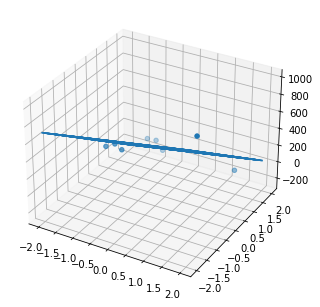

In [152]:
# Scale the data

%matplotlib inline

scaler = StandardScaler()
xtrain = scaler.fit_transform(X)
xtrain

# PLot the datapoints
from mpl_toolkits.mplot3d import Axes3D

# plot the train examples
f = plt.figure()
ax = Axes3D(f)
print(xtrain.shape, y.ravel().shape)
ax.scatter(xtrain[:,0], xtrain[:,1], y)

# Fit a simple linear regression
regressors = [LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor()]

for r in regressors:
    loo = LeaveOneOut()

    scores = cross_validate(r, xtrain, y, cv=5, scoring='neg_mean_squared_error')

    print(r, np.mean(scores['test_score']))


x1,x2 = np.meshgrid(np.linspace(-2,2), np.linspace(-2,2))

lr = regressors[0].fit(xtrain, y)
inter = lr.intercept_
coefs = lr.coef_

y_out = coefs[0]*x1+coefs[1]*x2 + inter
ax.plot_wireframe(x1,x2,y_out);

## Run the ANOVA test with all of the results


In [46]:



# Get the last accuracy instead of the list for the accuracy of each of the experiments

df = pd.DataFrame(res_final)

df

,cpu1-batch64-njobs1,cpu8-batch64-njobs1,cpu1-batch512-njobs1,cpu8-batch512-njobs1,cpu1-batch64-njobs5,cpu8-batch64-njobs5,cpu1-batch512-njobs5,cpu8-batch512-njobs5
time,494.060797,508.237879,178.124532,89.603111,552.377511,905.821336,187.054357,98.480282
accuracy,0.958800,0.960100,0.884300,0.890300,0.964800,0.959600,0.890800,0.893400
